In [1]:
!pip install pathway

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pathway as pw

In [3]:
# STEP 1: LOAD DATA
# You must upload the cleaned dataset with correct header including 'price' column
file_path = '/content/dataset.csv'
df = pd.read_csv(file_path)

In [4]:
# STEP 2: CREATE TIMESTAMP AND SORT
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], dayfirst=True)
df = df.sort_values(by=['SystemCodeNumber', 'timestamp']).reset_index(drop=True)
df.head()

,ID,SystemCodeNumber,Capacity,Occupancy,QueueLength,VehicleType,TrafficLevel,IsSpecialDay,Latitude,Longitude,LastUpdatedDate,LastUpdatedTime,price,timestamp
0,0,BHMBCCMKT01,577,61,1,car,low,0,26.144536,91.736172,04-10-2016,07:59:00,20,2016-10-04 07:59:00
1,1,BHMBCCMKT01,577,64,1,car,low,0,26.144536,91.736172,04-10-2016,08:25:00,20,2016-10-04 08:25:00
2,2,BHMBCCMKT01,577,80,2,car,low,0,26.144536,91.736172,04-10-2016,08:59:00,20,2016-10-04 08:59:00
3,3,BHMBCCMKT01,577,107,2,car,low,0,26.144536,91.736172,04-10-2016,09:32:00,20,2016-10-04 09:32:00
4,4,BHMBCCMKT01,577,150,2,bike,low,0,26.144536,91.736172,04-10-2016,09:59:00,20,2016-10-04 09:59:00


In [5]:
# STEP 3: FEATURE ENGINEERING
vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5, 'cycle': 0.3}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights)
traffic_levels = {'low': 1, 'average': 2, 'high': 3}
df['TrafficLevelEncoded'] = df['TrafficLevel'].map(traffic_levels)

In [6]:
# STEP 4: MODELING
def simple_price_model(row):
    # Simple rule-based model (Model 1)
    base_price = 20
    price = base_price + 5 * row['QueueLength']
    traffic_levels = {
    'low': 1,
    'average': 2,
    'high': 3
  }

    if row['TrafficLevelEncoded'] == 3:
        price += 10
    elif row['TrafficLevelEncoded'] == 1:
        price -= 5

    if row['VehicleType'].lower() == 'bike':
        price -= 5
    elif row['VehicleType'].lower() == 'truck':
        price += 10

    return max(price, 10)

df['price'] = df.apply(simple_price_model, axis=1)
features = ['Capacity', 'Occupancy', 'QueueLength', 'VehicleWeight', 'TrafficLevelEncoded', 'IsSpecialDay']
target = 'price'
vehicle_weights = {
    'car': 1.0,
    'bike': 0.5,
    'bus': 2.0,
    'truck': 2.5,
    'auto': 0.8
}

# Ensure lowercase vehicle types
df['VehicleType'] = df['VehicleType'].str.lower()

# Map to numeric weight
df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights)

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.impute import SimpleImputer

# Split into numeric and categorical features
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Impute only numeric columns using mean
imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])

# MODEL 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [7]:
# MODEL 2: Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
# EVALUATE
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

Linear Regression R2: 0.995567111279975
Random Forest R2: 0.9999134738688447


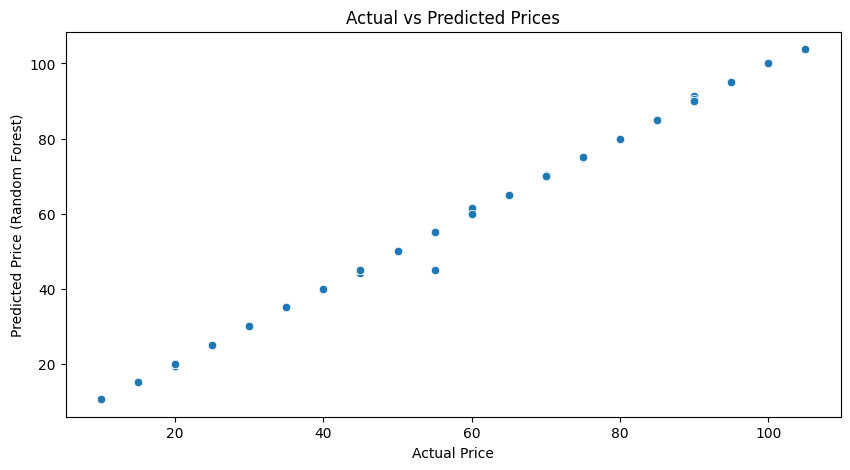

['ID', 'SystemCodeNumber', 'Capacity', 'Occupancy', 'QueueLength', 'VehicleType', 'TrafficLevel', 'IsSpecialDay', 'Latitude', 'Longitude', 'LastUpdatedDate', 'LastUpdatedTime', 'price', 'timestamp', 'VehicleWeight', 'TrafficLevelEncoded']


In [8]:
# STEP 5: VISUALIZATION
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price (Random Forest)")
plt.title("Actual vs Predicted Prices")
plt.show()
df.head()
print(df.columns.tolist())

In [9]:
import pandas as pd

df = pd.read_csv("/content/dataset.csv")
df.columns = [col.strip() for col in df.columns]

# Rename for consistency
df.rename(columns={'TrafficConditionNearby': 'TrafficLevel'}, inplace=True)

# Dummy price model
def simple_price_model(row):
    price = 20
    if row["TrafficLevel"].lower() == "heavy":
        price += 10
    if row["Occupancy"] > 0.8 * row["Capacity"]:
        price += 5
    return price

# Apply price
df['price'] = df.apply(simple_price_model, axis=1)

# Only keep relevant columns
required_columns = [
    "ID", "SystemCodeNumber", "Capacity", "Occupancy", "QueueLength",
    "VehicleType" ,"TrafficLevel", "IsSpecialDay",
    "Latitude", "Longitude", "LastUpdatedDate", "LastUpdatedTime", "price"
]
df_cleaned = df[required_columns]

# Save to CSV
df_cleaned.to_csv("/content/dataset.csv", index=False)


In [10]:

file_path = "/content/dataset.csv"

class ParkingSchema(pw.Schema):
    ID: int
    SystemCodeNumber: str
    Capacity: int
    Occupancy: int
    QueueLength: int
    VehicleType: str
    TrafficLevel: str
    IsSpecialDay: int
    Latitude: float
    Longitude: float
    LastUpdatedDate: str
    LastUpdatedTime: str
    price: float

# Load stream
parking_table = pw.io.csv.read(
    path=file_path,
    schema=ParkingSchema,
    mode='static',
    autocommit_duration_ms=1000
)

# Feature engineering
vehicle_weights = {"car": 1.0, "bike": 0.5, "truck": 2.0}
traffic_levels = {"low": 1, "average": 2, "high": 3}

def encode_vehicle(vtype):
    return vehicle_weights.get(vtype.lower(), 1.0)

def encode_traffic(level):
    return traffic_levels.get(level.lower(), 2)

pricing_table = parking_table.select(
    ID=parking_table.ID,
    SystemCodeNumber=parking_table.SystemCodeNumber,
    VehicleWeight=pw.apply(encode_vehicle, parking_table.VehicleType),
    TrafficLevelEncoded=pw.apply(encode_traffic, parking_table.TrafficLevel),
    Capacity=parking_table.Capacity,
    Occupancy=parking_table.Occupancy,
    QueueLength=parking_table.QueueLength,
    IsSpecialDay=parking_table.IsSpecialDay,
    timestamp=pw.apply(lambda d, t: f"{d} {t}", parking_table.LastUpdatedDate, parking_table.LastUpdatedTime)
)

# Predict using Model 2 (Random Forest)
def predict_price(cap, occ, ql, vw, tl, sd):
    input_df = pd.DataFrame([{
        'Capacity': cap,
        'Occupancy': occ,
        'QueueLength': ql,
        'VehicleWeight': vw,
        'TrafficLevelEncoded': tl,
        'IsSpecialDay': sd
    }])
    return float(rf.predict(input_df)[0])

pricing_table = pricing_table.select(
    ID=pricing_table.ID,
    SystemCodeNumber=pricing_table.SystemCodeNumber,
    timestamp=pricing_table.timestamp,
    PredictedPrice=pw.apply(
        predict_price,
        pricing_table.Capacity,
        pricing_table.Occupancy,
        pricing_table.QueueLength,
        pricing_table.VehicleWeight,
        pricing_table.TrafficLevelEncoded,
        pricing_table.IsSpecialDay
    )
)

# Output
pw.io.jsonlines.write(pricing_table, '/content/predicted_prices.jsonl')

# Run the app
pw.run()


Output()

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [11]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
import pandas as pd
import json

output_notebook()

# Load your predictions
with open('/content/predicted_prices.jsonl', 'r') as f:
    lines = [json.loads(line) for line in f]

df = pd.DataFrame(lines)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort values just in case
df = df.sort_values(by='timestamp')

# Plot for each SystemCodeNumber
unique_lots = df['SystemCodeNumber'].unique()
p = figure(x_axis_type='datetime', title='Dynamic Pricing Over Time')

colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'navy', 'gold', 'teal', 'black', 'pink', 'gray', 'lime', 'cyan']

for i, lot in enumerate(unique_lots):
    lot_df = df[df['SystemCodeNumber'] == lot]
    source = ColumnDataSource(lot_df)
    p.line(x='timestamp', y='PredictedPrice', source=source, legend_label=f'Lot {lot}', color=colors[i % len(colors)])

p.legend.click_policy = "hide"
p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Price ($)"

show(p)


/tmp/ipython-input-11-1255709054.py:15: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['timestamp'] = pd.to_datetime(df['timestamp'])
